# Clean Slate: Estimating offenses eligible for expungement under varying conditions
> Prepared by [Laura Feeney](https://github.com/laurafeeney) for Code for Boston's [Clean Slate project](https://github.com/codeforboston/clean-slate).

## Purpose
This notebook takes somewhat processed data from the Northwestern DA and answers the following questions, posed June 28, 2020. 

This analysis will be run a number of times: under existing regulation, and under varying conditions allowing additional offenses to be expunged.


1. How many people (under age 21) are eligible for expungement today? This would be people with only **one charge** that is not part of the list of ineligible offenses (per section 100J). 


2. How many people (under age 21) would be eligible based on only having **one incident** (which could include multiple charges) that are not part of the list of ineligible offenses?
 - How many people (under age 21) would be eligible based on only having **one incident** if only sex-based offenses or murder were excluded from expungement?
 

3. How many people (under age 21) would be eligible based on who has **not been found guilty** (given current offenses that are eligible for expungement)?
 - How many people (under age 21) would be eligible based on who has **not been found guilty** for all offenses except for murder or sex-based offenses?

-----

### Step 0
Import data, programs, etc.

-----

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 200)
import numpy as np
import regex as re
import glob, os
import datetime 
from datetime import date 
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [2]:
# processed individual-level data from NW district with expungability.

nw = pd.read_csv('../../data/processed/merged_nw.csv', encoding='utf8',
                    dtype={'Analysis notes':str, 'extra_criteria':str, 'Expungeable': str}) 

nw['Expungeable'].value_counts(dropna=False)


Yes              55052
No               20013
NotApplicable      439
Attempt            220
NaN                  1
Name: Expungeable, dtype: int64

In [3]:
nw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75725 entries, 0 to 75724
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Person ID               75725 non-null  object 
 1   Court                   75725 non-null  object 
 2   Offense Date            74915 non-null  object 
 3   Age at Offense          74783 non-null  float64
 4   Filed                   75725 non-null  object 
 5   Status                  75725 non-null  object 
 6   Count                   75725 non-null  int64  
 7   Charge                  75725 non-null  object 
 8   Disposition             72259 non-null  object 
 9   Dispo Date              71881 non-null  object 
 10  CMRoffense              75725 non-null  object 
 11  Chapter                 72457 non-null  object 
 12  Section                 72588 non-null  object 
 13  sex                     75725 non-null  int64  
 14  murder                  75725 non-null

## Step 0.5 - Prepare data

- Drop CMR offenses
- Prepare dates, date since offense
- Generate indicators for incidents, and code incidents as expungeable, sex-related etc
- Generate indicator for found guilty / not found guilty 

**CMR** : There are many offenses that are violations of the Code of Massachusetts Regulations (CMR) rather than a criminal offense. These include things like some driving or boating infractions (e.g., not having headlights on), or not having a hunting/fishing license. Per conversations with Sana, dropping all CMR offenses.

**Dates and ages. Drop negative and null ages, look at date ranges**

The file name suggests this should be from 2014-2018: 

Prosecution Northwestern DA 2014-2018 RAW DATA - 2014 to early 2018.csv, and 
Prosecution Northwestern DA 2014-2018 RAW DATA - to end of 2018.csv

In [4]:
#convert to datetime
reference_date = datetime.date(2020, 9, 1) # using "today.date() wouldn't be stable"

nw['Offense Date'] = pd.to_datetime(nw['Offense Date']).dt.date
nw['years_since_offense'] = round((reference_date - nw['Offense Date'])/pd.Timedelta(1, 'D')/365,1)

invalid_age = nw['Age at Offense'][(nw['Age at Offense']<=0) | (nw['Age at Offense'].isnull()) ]
perc_invalid = "{:.2%}".format(invalid_age.shape[0] / nw['Age at Offense'].shape[0])
invalid_age_pp = nw['Person ID'][(nw['Age at Offense']<=0) | (nw['Age at Offense'].isnull()) ].nunique()
perc_invalid_pp = "{:.2%}".format(invalid_age_pp/nw['Person ID'].nunique() )


print('Records with negative or null age: ', invalid_age.shape[0], ',', perc_invalid)
print('Unique individuals with negative or null age: ', invalid_age_pp, ',', perc_invalid_pp)

print("Drop those without an age <=0 or null age. The date of these offenses is also sometimes inconceivable (eg, 1750)")

nw = nw[(nw['Age at Offense']>0) & ~(nw['Age at Offense'].isnull()) ].copy()

offenses_2014_2018 = nw['Offense Date'].loc[
    (nw['Offense Date'] >= datetime.date(2014, 1, 1)) & 
    (nw['Offense Date'] <= datetime.date(2018, 12, 31))].count()

Percent_14_18 = "{:.2%}".format(offenses_2014_2018/nw['Offense Date'].count())
             
print('Percent of offenses between Jan 1 2014 and Dec 31 2018: ', Percent_14_18)

print("The earliest offense date is", min(nw['Offense Date']))
print("The max offense date is", max(nw['Offense Date']), "\n")

Records with negative or null age:  1128 , 1.49%
Unique individuals with negative or null age:  251 , 1.27%
Drop those without an age <=0 or null age. The date of these offenses is also sometimes inconceivable (eg, 1750)
Percent of offenses between Jan 1 2014 and Dec 31 2018:  96.57%
The earliest offense date is 1975-08-01
The max offense date is 2018-12-30 



In [5]:
# CMR: Drop all CMR offenses and Drop CMR-related columns

print(f'There are {nw.shape[0]} total offenses including CMR.')

nw = nw.loc[nw['CMRoffense'] == 'no']
nw = nw.drop(columns = ['CMRoffense'])

print(f'After we drop CMR, there are {nw.shape[0]} total offenses.')


There are 74597 total offenses including CMR.
After we drop CMR, there are 74164 total offenses.


In [6]:
#Incidents

#Number of incidents (separate offense dates per same ID)
nw['Incidents'] = (nw.groupby('Person ID')['Offense Date'].transform('nunique'))

# If an incident includes one offense that is not expungeable, we mark the entire incident as not expungeable.

#Attempts *are not* considered expungeable in this one. 
nw['Exp'] = nw['Expungeable']=="Yes"
nw['Inc_Expungeable_Attempts_Not'] = nw.groupby(['Person ID', 'Offense Date'])['Exp'].transform('min')

#Attempts *are* considered expungeable in this one. 
nw['ExpAtt'] = (nw['Expungeable']=="Yes") | (nw['Expungeable']=="Attempt")
nw['Inc_Expungeable_Attempts_Are'] = nw.groupby(['Person ID', 'Offense Date'])['ExpAtt'].transform('min')

# If an incident includes an offense that is a murder and/or sex crime, we code the whole incident as regarding
# murder and/or sex.
nw['sm'] = (nw['sex'] == 1) | (nw['murder'] ==1)
nw['Incident_Murder_Sex'] = nw.groupby(['Person ID', 'Offense Date'])['sm'].transform('max')

#drop unneeded calculation columns
nw = nw.drop(columns=['Exp', 'ExpAtt', 'sm'])

**Dispositions and Guilty**
Referencing this sheet to determine which to code as not found guilty vs found guilty.
https://docs.google.com/spreadsheets/d/1axzGGxgQFPwpTw7EbBlC519L43fOkqC5/edit#gid=487812267

In [7]:
sorted(nw['Disposition'].loc[nw['Disposition'].notnull()].unique())

['Accord/Satisfaction',
 'Agreed Plea',
 'CLOSED-INDICTED',
 'CLOSED-NO CHARGES',
 'Case Transferred',
 'Charge Handled as a Civil Charge',
 'Continued w/o Finding',
 'Continued/Valor Act',
 "DA's Complaint",
 'DYS Committed',
 'Delinquent',
 'Delinquent Filed',
 'Directed Verdict',
 'Dismissed',
 'Dismissed - Lack of Prosecution',
 'Dismissed Prior to Arraignment',
 'Dismissed at Request of Comm',
 'Dismissed by Court',
 'Dismissed on Payment',
 'Dismissed prior to complaint',
 'District Court Dispo',
 'Found Incompetent',
 'Guilty',
 'Guilty Filed',
 'Guilty on Lesser Included Offense',
 'NGI',
 'No Time to Reach',
 'Nolle Prosequi',
 'Not Guilty',
 'Not Guilty by Reason of Mental Illness',
 'Not Responsible',
 'Required Finding of Not Guilty',
 'Responsible',
 'Responsible Filed',
 'Unagreed Plea',
 'Valor Act Dispo',
 'Youthful Offender',
 'c276s87 finding']

In [8]:
nw['Disposition'].count()

70879

In [9]:
len(nw['Person ID'])

74164

In [10]:
guilty_dispos = ['Agreed Plea', 'c276s87 finding', 
                 'Delinquent', 'Delinquent Filed', 'Guilty', 'Guilty Filed', 
                 'Guilty on Lesser Included Offense',
                'Responsible', 'Responsible Filed', 
                 'Unagreed Plea', 'Youthful Offender']
nw['guilty'] = nw['Disposition'].isin(guilty_dispos)
nw.loc[nw.Disposition.isnull(), 'guilty'] = 2 
nw['Incident_Guilty'] = nw.groupby(['Person ID', 'Offense Date'])['guilty'].transform('max')

In [11]:
nw['guilty'].value_counts(dropna=False)

False    50732
True     20147
2         3285
Name: guilty, dtype: int64

## Step 1
summary stats

In [12]:
# dates
print('Age distribution\n', nw['Age at Offense'].describe())

print("The earliest offense date is", min(nw['Offense Date']))
print("The max offense date is", max(nw['Offense Date']), "\n")

Age distribution
 count    74164.000000
mean        32.988040
std         12.172062
min          1.000000
25%         23.000000
50%         30.000000
75%         41.000000
max         94.000000
Name: Age at Offense, dtype: float64
The earliest offense date is 1975-08-01
The max offense date is 2018-12-30 



In [13]:
# distribution of # of charges

nw['num_offenses']=nw.groupby('Person ID')['Person ID'].transform('count')
print(nw['num_offenses'].describe())

print('\n cutting off top 1%: \n', nw['num_offenses'].loc[nw['num_offenses']< nw['num_offenses'].quantile(.99)].describe())

#nw.loc[nw['num_offenses']<30].hist(column='num_offenses', bins=15)

count    74164.000000
mean         9.309638
std         14.502255
min          1.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        202.000000
Name: num_offenses, dtype: float64

 cutting off top 1%: 
 count    73404.000000
mean         8.225138
std          8.190213
min          1.000000
25%          3.000000
50%          5.000000
75%         11.000000
max         64.000000
Name: num_offenses, dtype: float64


In [14]:
### number of unique people, offenses
Number_People = nw['Person ID'].nunique()
Number_Juvenile = nw[ (~nw['Age at Offense'].isnull()) & (nw['Age at Offense']<21)]['Person ID'].nunique()
Percent_Juvenile = "{:.2%}".format(Number_Juvenile/Number_People)
Number_Adult = nw[ (~nw['Age at Offense'].isnull()) & (nw['Age at Offense']>=21)]['Person ID'].nunique()
Percent_Adult = "{:.2%}".format(Number_Adult/Number_People)

Number_18 = nw[ (~nw['Age at Offense'].isnull()) & (nw['Age at Offense']<18)]['Person ID'].nunique()
Percent_18 = "{:.2%}".format(Number_18/Number_People)

ind_one_off = nw[nw['num_offenses']==1]['Person ID'].nunique()
ind_one_inc = nw[nw['Incidents']==1]['Person ID'].nunique()

off_one_off = nw[nw['num_offenses']==1].shape[0]
inc_one_inc = nw[nw['Incidents']==1].groupby(['Person ID', 'Offense Date']).ngroups

Juvenile_one_off = nw[(nw['num_offenses']==1) & 
                      (~nw['Age at Offense'].isnull()) & 
                      (nw['Age at Offense']<21) ]['Person ID'].nunique()

Juvenile_one_off_18 = nw[(nw['num_offenses']==1) & 
                      (~nw['Age at Offense'].isnull()) & 
                      (nw['Age at Offense']<18) ]['Person ID'].nunique()

In [15]:
total = ['Total individuals', Number_People]
oneoff = ['Individuals with a single offense', ind_one_off , '{:,.2%}'.format(ind_one_off/Number_People)]
oneinc = ['Individuals with a single incident', ind_one_inc, '{:,.2%}'.format(ind_one_inc/Number_People)]



adult = ['Total individuals >= 21*',Number_Adult, Percent_Adult]
juvenile = ['Total individuals < 21*', Number_Juvenile, Percent_Juvenile]
juv_one_off = ['Individuals < 21 with a single offense', Juvenile_one_off, '{:,.2%}'.format(Juvenile_one_off/Number_People)]        
under18 = ['Total individuals < 18*', Number_18, Percent_18]
u18_one_off = ['Individuals < 18 with a single offense', Juvenile_one_off_18, '{:,.2%}'.format(Juvenile_one_off_18/Number_People)]  
         
stats = [total, oneoff, oneinc, adult, juvenile, juv_one_off, under18, u18_one_off]
statsdf = pd.DataFrame(stats, columns = ['Question', 'Number', '% total individuals'])
statsdf = statsdf.set_index('Question')
statsdf
statsdf.style.format({'Number' : '{:,}'})

,Number,% total individuals
Question,,
Total individuals,"19,517",None
Individuals with a single offense,"4,988",25.56%
Individuals with a single incident,"13,112",67.18%
Total individuals >= 21*,"17,193",88.09%
Total individuals < 21*,"2,770",14.19%
Individuals < 21 with a single offense,708,3.63%
Total individuals < 18*,795,4.07%
Individuals < 18 with a single offense,221,1.13%


In [16]:
# offenses related to sex or murder
Nu_tot = nw['Charge'].count()
Incidents_tot = nw.groupby(['Person ID', 'Offense Date']).ngroups

Nu_sex = nw[nw['sex'] == 1]['sex'].count()
Nu_murder = nw[nw['murder'] == 1]['murder'].count()
Nu_sex_murder = nw[nw['Incident_Murder_Sex']  == 1]['Incident_Murder_Sex'].count()
Nu_sex_murder_inc = nw[nw['Incident_Murder_Sex']  == 1].groupby(['Person ID', 'Offense Date']).ngroups

Percent_sex = "{:.2%}".format(Nu_sex / Nu_tot )
Percent_murder = "{:.2%}".format(Nu_murder / Nu_tot )
Percent_incident_sex_murder = "{:.2%}".format(Nu_sex_murder_inc / Incidents_tot)

In [17]:
off_one_off1 = ['Offenses committed by individuals with one offense', off_one_off, '{:,.2%}'.format(off_one_off/Nu_tot), '{:,.2%}'.format(off_one_off/Incidents_tot)]
inc_one_inc1 = ['Incidents committed by individuals with one incident', inc_one_inc, '', '{:,.2%}'.format(inc_one_inc/Incidents_tot)]

sex_offenses = ['Sex offenses', Nu_sex, Percent_sex]
murder = ['Murder offenses', Nu_murder, Percent_murder]
sex_murder = ['Incidents with sex or murder offenses', Nu_sex_murder_inc,'', Percent_incident_sex_murder]
incidents = ['Total incidents', Incidents_tot]
offenses = ['Total offenses', Nu_tot]

stats = [offenses, incidents, off_one_off1, inc_one_inc1, sex_offenses, murder, sex_murder]
statsdf = pd.DataFrame(stats, columns = ['Offense and Incident Stats','Number', '% total offenses', '% total incidents'])
statsdf = statsdf.set_index('Offense and Incident Stats')

statsdf.style.format({'Number' : '{:,}'})

,Number,% total offenses,% total incidents
Offense and Incident Stats,,,
Total offenses,"74,164",None,None
Total incidents,"33,069",None,None
Offenses committed by individuals with one offense,"4,988",6.73%,15.08%
Incidents committed by individuals with one incident,"13,112",,39.65%
Sex offenses,"1,489",2.01%,None
Murder offenses,148,0.20%,None
Incidents with sex or murder offenses,680,,2.06%


# Analysis
For all questions, we assume 'attempts' are eligible for expungement. They are highly infrequent, and we do not have sufficient information in most cases to determine actual eligiblity. 
Changing "expungeable == 'yes'" would reverse this and make attempts ineligible. 

## Question 1
- How many people are eligible for expungement today? 
    - ---> *Only one charge*, Offense committed before 21st birthday, charge is not part of the list of ineligible offenses (per section 100J), charge is in the correct timeframe from today's date

We don't have misdemeanor / felony info, so will show the # that are more than 3 or more than 7 years from today.

----

In [18]:
def date_range(x):
    greater3 = x.loc[(x['years_since_offense'] > 3)]['Person ID'].nunique()
    greater7 = x.loc[(x['years_since_offense'] > 7)]['Person ID'].nunique()

    print(greater3, "occured more than 3 years before", reference_date)
    print(greater7, "occured more than 7 years before", reference_date)
    
def eligible_juvs(y):
    People_eligible = y['Person ID'].nunique()
    pct_juv = '{:.2%}'.format(People_eligible/Number_Juvenile)
    return People_eligible , pct_juv
    
def eligible_all_ages(y):
    People_eligible = y['Person ID'].nunique()
    pct_tot = '{:.2%}'.format(People_eligible/Number_People)
    return People_eligible, pct_tot

In [19]:
# Single eligible offense; under 21
x = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] != 'No') &
    (nw['Age at Offense']<21)
]

q1 = 'q1', 'Eligible today: single eligible offense', eligible_juvs(x)
print(q1)

date_range(x)

print("\nDispositions: \n\n", x.Disposition.value_counts(dropna=False))

('q1', 'Eligible today: single eligible offense', (525, '18.95%'))
367 occured more than 3 years before 2020-09-01
10 occured more than 7 years before 2020-09-01

Dispositions: 

 c276s87 finding                     151
Dismissed at Request of Comm         92
Responsible                          75
Nolle Prosequi                       47
Dismissed Prior to Arraignment       41
Dismissed                            31
Continued w/o Finding                25
Dismissed on Payment                 25
NaN                                  24
Guilty                                4
Delinquent                            3
Charge Handled as a Civil Charge      3
Dismissed by Court                    3
Responsible Filed                     1
Name: Disposition, dtype: int64


In [20]:
# Single eligible offense; all ages
x = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] != 'No') 
]

print("# and % with single eligible offense of all ages: ", eligible_all_ages(x))

#add all ages to q1
q1 = q1, eligible_all_ages(x)

# and % with single eligible offense of all ages:  (3538, '18.13%')


## Question 2: incidents rather than offenses

Luke Schissler & Laura Feeney

2. How many people (under age 21) would be eligible based on only having **one incident** (which could include multiple charges) that are not part of the list of ineligible offenses?
 - 2a. How many people (under age 21) would be eligible based on only having **one incident** if only sex-based offenses or murder were excluded from expungement?


Making the assumption based on the 06/26/20 meeting notes that an 'incident' is defined as the sum of all charges for an individual on a single day. In theory, someone could probably be charged in two separate instances on a single day, but this is likely rare. 

For this analysis, we assume that a single non-expungeable offense under the bundle of the incident makes the entire incident non-expungeable. Same for the analysis of murder or sex crimes.

### How many people (under age 21) would be eligible based on only having one incident (which could include multiple charges) that are not part of the list of ineligible offenses?

In [21]:
# Find how many people whose offenses fall into a single incident, where all the offenses are expungeable 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (nw['Age at Offense']<21) 
]

q2 = 'q2', 'Single incident: no offenses ineligible', eligible_juvs(x)
print(q2)

date_range(x)

print("\nDispositions: \n\n", x.Disposition.value_counts(dropna=False))

('q2', 'Single incident: no offenses ineligible', (1198, '43.25%'))
823 occured more than 3 years before 2020-09-01
21 occured more than 7 years before 2020-09-01

Dispositions: 

 Dismissed at Request of Comm        505
c276s87 finding                     447
Nolle Prosequi                      240
Continued w/o Finding               221
Responsible                         207
Not Responsible                     201
Dismissed Prior to Arraignment      152
Dismissed                           112
NaN                                  98
Dismissed on Payment                 84
Guilty                               32
Delinquent                           14
Dismissed by Court                   14
Responsible Filed                    13
Found Incompetent                     8
DYS Committed                         5
Charge Handled as a Civil Charge      5
Delinquent Filed                      3
Dismissed prior to complaint          3
CLOSED-NO CHARGES                     3
Unagreed Plea      

In [22]:
# Compare the above for full file.
#  how many offenses fall into a single incident, where all the offenses are expungeable 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Are'] == True) 
]

#add all ages
q2 = q2, eligible_all_ages(x)
print(q2)

(('q2', 'Single incident: no offenses ineligible', (1198, '43.25%')), (8380, '42.94%'))


### 2b - How many would be eligible if we only limited to only exclude sex-based offenses or murder?
**Limiting to those with one incident**

In [23]:
x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Murder_Sex'] == 0) &
    (nw['Age at Offense']<21) 
]

q2b = 'q2b', 'Single incident: no offenses related to sex or murder', eligible_juvs(x)
print(q2b)

date_range(x)

print("\nTop 10 Dispositions: \n\n", x.Disposition.value_counts(dropna=False)[0:10])

('q2b', 'Single incident: no offenses related to sex or murder', (1699, '61.34%'))
1187 occured more than 3 years before 2020-09-01
27 occured more than 7 years before 2020-09-01

Top 10 Dispositions: 

 Dismissed at Request of Comm      744
c276s87 finding                   652
Continued w/o Finding             454
Nolle Prosequi                    439
Not Responsible                   344
Responsible                       234
Dismissed Prior to Arraignment    193
Dismissed                         140
NaN                               132
Dismissed on Payment               88
Name: Disposition, dtype: int64


In [24]:
#all ages
x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Murder_Sex'] == 0)
]
q2b = q2b, eligible_all_ages(x)

### Not limiting by number of incidents

In [25]:
x = nw.loc[
    (nw['Incident_Murder_Sex'] == 0) &
    (nw['Age at Offense']<21) 
]

q2b2 = 'q2b2', 'Any incident: no offenses related to sex or murder', eligible_juvs(x)
print(q2b2)

x = nw.loc[
    (nw['Incident_Murder_Sex'] == 0) 
]
q2b2 = q2b2, eligible_all_ages(x)
#print("\nTop 10 Dispositions: \n\n", x.Disposition.value_counts(dropna=False)[0:10])

('q2b2', 'Any incident: no offenses related to sex or murder', (2709, '97.80%'))


## Question 3: Verdict as Determiner

**Question 3a** -  How many would be eligible based on who has not been found guilty (given current offenses that are eligible for expungement)?

'Guilty' is defined above in section 0.5

In [26]:
# Find how many people are eligble for expungement if they have a single incident, in which all the offenses are 
# expungeable, and none have a guilty verdict. 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (nw['Incident_Guilty'] == False) &
    (nw['Age at Offense']<21)
]

q3 = 'q3', 'Single incident: no ineligible offenses; no guilty dispositions', eligible_juvs(x)
print(q3)

#All ages
x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (nw['Incident_Guilty'] == False)
]

q3 = q3, eligible_all_ages(x)
print(q3)

('q3', 'Single incident: no ineligible offenses; no guilty dispositions', (640, '23.10%'))
(('q3', 'Single incident: no ineligible offenses; no guilty dispositions', (640, '23.10%')), (5034, '25.79%'))


In [27]:
# Any incident in which no offenses have a guilty verdict and no offenses are ineligible for expungement

x = nw.loc[
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (nw['Incident_Guilty'] == False) &
    (nw['Age at Offense']<21)
]

q3a = 'q3a', 'Any incident: no ineligible offenses; no guilty dispositions', eligible_juvs(x)
print(q3a)

x.Disposition.value_counts(dropna=False)

# All Ages
x = nw.loc[
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (nw['Incident_Guilty'] == False)
]
q3a = q3a, eligible_all_ages(x)
print(q3a)

('q3a', 'Any incident: no ineligible offenses; no guilty dispositions', (1200, '43.32%'))
(('q3a', 'Any incident: no ineligible offenses; no guilty dispositions', (1200, '43.32%')), (9038, '46.31%'))


Repeating the above, but using incidents rather than offenses. 

**Question 3b** -  How many would be eligible based on who has not been found guilty, except murder or sex offenses?


In [28]:
#Find out how many people would be eligible if they have a single incident, in which all the charges are unrelated to
#sex or murder, and all charges have a disposition other than guilty. 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Guilty'] == False) &
    (nw['Incident_Murder_Sex'] == False) &
    (nw['Age at Offense']<21) 
]

q3b = 'q3b', 'Single incident: no offenses related to sex or murder, no guilty dispositions', eligible_juvs(x)
print(q3b)

#all ages
x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Guilty'] == False) &
    (nw['Incident_Murder_Sex'] == False) 
]
q3b = q3b, eligible_all_ages(x)
print(q3b)

('q3b', 'Single incident: no offenses related to sex or murder, no guilty dispositions', (956, '34.51%'))
(('q3b', 'Single incident: no offenses related to sex or murder, no guilty dispositions', (956, '34.51%')), (7839, '40.16%'))


In [29]:
#Remove incident limitation. People with any incident in which no charges are related to sex or murder nor are found guilty.

x = nw.loc[
    (nw['Incident_Guilty'] == False) &
    (nw['Incident_Murder_Sex'] == False) &
    (nw['Age at Offense']<21) 
]

q3b1 = 'q3b1', 'Any incident: no offenses related to sex or murder, no guilty dispositions', eligible_juvs(x)
print(q3b1)

#all ages
x = nw.loc[
    (nw['Incident_Guilty'] == False) &
    (nw['Incident_Murder_Sex'] == False) 
]
q3b1 = q3b1, eligible_all_ages(x)
print(q3b1)

('q3b1', 'Any incident: no offenses related to sex or murder, no guilty dispositions', (1729, '62.42%'))
(('q3b1', 'Any incident: no offenses related to sex or murder, no guilty dispositions', (1729, '62.42%')), (13141, '67.33%'))


In [30]:
a = [q1, q2, q2b, q2b2, q3, q3a, q3b, q3b1]
ans = pd.DataFrame(a)
ans = pd.DataFrame(a , columns = ['A', 'B'])
ans[['q', 'Question', 'Juv']] = pd.DataFrame(ans['A'].tolist())  
ans[['Num Juv', 'Pct Juv']] = pd.DataFrame(ans['Juv'].tolist()) 
ans[['Num All Ages', 'Pct All Ages']] = pd.DataFrame(ans['B'].tolist())  
ans = ans[['q', 'Question', 'Num Juv', 'Pct Juv', 'Num All Ages', 'Pct All Ages']].set_index('q')
ans.style.format({'Num Juv':'{:,}', 'Num All Ages':'{:,}'})

,Question,Num Juv,Pct Juv,Num All Ages,Pct All Ages
q,,,,,
q1,Eligible today: single eligible offense,525,18.95%,"3,538",18.13%
q2,Single incident: no offenses ineligible,"1,198",43.25%,"8,380",42.94%
q2b,Single incident: no offenses related to sex or murder,"1,699",61.34%,"12,874",65.96%
q2b2,Any incident: no offenses related to sex or murder,"2,709",97.80%,"19,238",98.57%
q3,Single incident: no ineligible offenses; no guilty dispositions,640,23.10%,"5,034",25.79%
q3a,Any incident: no ineligible offenses; no guilty dispositions,"1,200",43.32%,"9,038",46.31%
q3b,"Single incident: no offenses related to sex or murder, no guilty dispositions",956,34.51%,"7,839",40.16%
q3b1,"Any incident: no offenses related to sex or murder, no guilty dispositions","1,729",62.42%,"13,141",67.33%


## Summary info
Top 10 offenses etc

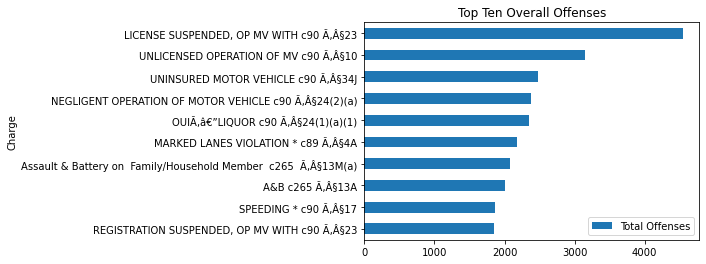

In [31]:
# TOP TEN OVERALL OFFENSES
overall_offenses = nw.groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
overall_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')

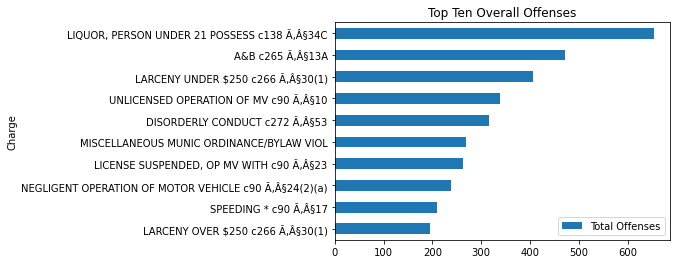

In [32]:
# TOP TEN JUVENILE OFFENSES
juvenile_offenses = nw[(~nw['Age at Offense'].isnull()) & (nw['Age at Offense']<21)].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
juvenile_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')

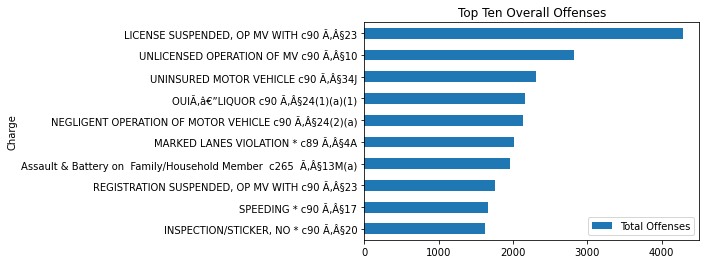

In [33]:
# TOP TEN ADULT OFFENSES
adult_offenses = nw[(~nw['Age at Offense'].isnull()) & (nw['Age at Offense']>=21)].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
adult_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')